#Introduction
This project is **Machine Learning for Computer Vision project work** from the second year of the master's program Artificial Intelligence in Bologna done by **Davide Brescia** (davide.brescia@studio.unibo.it - 0001036867).

The final model will be able to:
*   **INPUT**: *video* of a basketball game
*   **OUTPUT**: *text file* in which there are written the minutes of the shoots on target made

Different approaches will be used to arrive at the best result, specifically 3 steps will follow:

*   **[Part 1] Binary classification on 1280x720 images**: I used a dataset consisting of 430, 1280x720 screenshots of 83 basketball games with a *baseline model* and with *resnet50*. These screenshots are divided into *point* (when the ball is inside the basket or has noticeably deformed the retina) and *no-point* (all other cases).
*   **[Part 2] Binary classification on 128x128 and 1280x720 images**: I decided to perform a cropping of these screenshots (plus other 6000 images) obtaining 128x128 images showing only the basket.
* **[Part 3] Basket Localization and binary classification on 128x128 images**: since the previous model was able to distinguish basket and non-basket in 128x128 images, it might be a good idea to give the previous model only cropped images. Unfortunately, however, as specified above, the images I use for work are 1280x720, so I decided to train yolov5's small model to locate the basket, crop it, and give it as input to the previous model.


# Imports

In [ ]:
import os, random, shutil

!pip install gdown
!pip install --upgrade gdown
import gdown

import zipfile

import cv2

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
print("PyTorch Version: ",torch.__version__)

from torchsummary import summary

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm

from typing import Tuple, Union, Callable, Dict, List

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

from timeit import default_timer as timer

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image

from google.colab.patches import cv2_imshow

from scipy import signal

import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


# Utility Functions

### Utility

In [ ]:
def read_from_text(text_path: str) -> str:
  """
  Reads a file from text.
  The files will usually consist of a single line containing
  the minutes of the baskets (grand truth)

  Args:
        text_path: path of the txt file

  Returns:
        points_text: content inside the txt file in path text_path
  """
  points_text = ""

  with open(text_path, 'r') as f:
      for line in f:
          points_text += line
  return points_text

In [ ]:
def hms_to_s(hms: str) -> int:
  """
  Transforms an hour, minute and second format string into seconds 

  Args:
        hms: str in format hour, minute and second

  Returns:
        seconds: seconds corresponding to the format hours minutes seconds
  """
  if len(hms.split(':')) == 1:
    return int(hms)
  elif len(hms.split(':')) == 2:
    m = int(hms.split(':')[0])
    s = int(hms.split(':')[1])
    return m*60 + s
  else:
    h = int(hms.split(':')[0])
    m = int(hms.split(':')[1])
    s = int(hms.split(':')[2])
    return h*3600 + m*60 + s

In [ ]:
def frame_to_hms(frame: int, fps: int) -> str:
  """
  Transforms a frame count into hour, minute and second format string 

  Args:
        frame: frame count of a particular video
        fps: frame per seconds of a particular video

  Returns:
        hms: str in hour, minute and second format
  """
  all_sec = int(frame/fps)
  all_m = int(all_sec/60)
  s = all_sec%60
  m = all_m%60
  h = int(all_m/60)
  return f"{h}:{m}:{s}"

### Reproducibility

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Dataset Class

In [ ]:
class DatasetClass:
  """
  A class representing the dataset under consideration. 
  Splits in the dataset and dataloader will be considered as dictionaries,
  the user can then use the following wording to obtain the desired split:

  ds = DatasetClass(args ...)

  ds['DATASET-NAME'].dataset['full'] <- obtain the full dataset
  ds['DATASET-NAME'].dataset['train'] <- obtain the train dataset (if allowed in the initilization)
  ds['DATASET-NAME'].dataset['val'] <- obtain the val dataset (if allowed in the initilization)
  ds['DATASET-NAME'].dataset['test'] <- obtain the val dataset (if allowed in the initilization)

  ds['DATASET-NAME'].dataloader['full'] <- obtain the full dataloader
  ds['DATASET-NAME'].dataloader['train'] <- obtain the train dataloader (if allowed in the initilization)
  ds['DATASET-NAME'].dataloader['val'] <- obtain the val dataloader (if allowed in the initilization)
  ds['DATASET-NAME'].dataloader['test'] <- obtain the test dataloader (if allowed in the initilization)
  """
  def __init__(self, 
               extraction_path : str, 
               dataset_name : str,  
               train_batchsize : int,
               eval_batchsize : int, 
               split_dimension : list,
               transform : torchvision.transforms):
  
    """
    Initialize the DatasetClass

    Args:
          extraction_path: directory where to extract the dataset
          dataset_name: database name (folder name)
          train_batchsize: train batch size
          eval_batchsize: test and val batch size
          split_dimension: split proportions, you can chose between:
            [1] -> no split at all, only the 'full' option in the dictionaries will be available
            [x, y] -> one split, 'full', 'train', 'val' option are available in the dictionaries
            [x, y, z] -> two splits, 'full', 'train', 'val' and 'test' option are available in the dictionaries
          transform: the transform to apply to the data
    """

    #Construct the dataset_path
    self.dataset_path = "/content/" + dataset_name

    #Extract the dataset in the content folder
    with zipfile.ZipFile(extraction_path, 'r') as zip_ref:
      zip_ref.extractall("/content")

    #Assign the transform and get the number of split
    self.transform = transform
    self.n_splits = len(split_dimension)

    self.dataset = {}
    #generate the entire dataset ImageFolder 
    self.dataset['full'] = datasets.ImageFolder(self.dataset_path, transform = self.transform)

    #If we ask for a split, the class will create train and validation split
    if self.n_splits == 2:
      splits = torch.utils.data.random_split(self.dataset['full'], split_dimension)
      self.dataset['train'], self.dataset['val'] = splits[0], splits[1]
    
    #If we ask for two split, the class will create train, validation and test splits
    if self.n_splits == 3:
      splits = torch.utils.data.random_split(self.dataset['full'], split_dimension)
      self.dataset['train'], self.dataset['val'], self.dataset['test'] = splits[0], splits[1], splits[2]

    num_workers = os.cpu_count()

    #Assign batchsize
    self.train_batchsize = train_batchsize
    self.eval_batchsize = eval_batchsize

    
    self.dataloader = {}
    #Create the full dataloader of the dataset (it might be useful for experiments)
    self.dataloader['full'] = torch.utils.data.DataLoader(self.dataset['full'],
                                            batch_size = self.train_batchsize,
                                            shuffle = False, num_workers = num_workers)

    #If we ask for a split, the class will create train and validation dataloaders
    if self.n_splits > 1:
      self.dataloader['train'] = torch.utils.data.DataLoader(self.dataset['train'], 
                                                batch_size = self.train_batchsize, 
                                                shuffle = True, pin_memory = True, 
                                                num_workers = num_workers)
      
      self.dataloader['val'] = torch.utils.data.DataLoader(self.dataset['val'],
                                                batch_size = self.eval_batchsize,
                                                shuffle = False, num_workers = num_workers)
    
    #If we ask for two split, the class will create train, validation and test dataloaders
    if self.n_splits > 2:
      self.dataloader['test'] = torch.utils.data.DataLoader(self.dataset['test'],
                                            batch_size = self.eval_batchsize,
                                            shuffle = False, num_workers = num_workers)

### Baseline Class

In [ ]:
class BaselineModel(nn.Module):
  """
  A simple CNN that contains 3 convolutional layer followed respectively by
  1 maxpooling layer, then a global max pooling and at the end we have two linear layer.
  The output has dimension one, we have a single output that represent the probability
  to have a point given an image (I'll use a sigmoid at the end). 
  """
  def __init__(self) -> None:
      super().__init__()
      
      self.conv1 = nn.Conv2d(3, 6, 3)
      self.conv2 = nn.Conv2d(6, 12, 3)
      self.conv3 = nn.Conv2d(12, 24, 3)

      self.max_pool = nn.MaxPool2d(3)

      self.adp_max_pool = nn.AdaptiveMaxPool2d(1)
      
      self.sigmoid = nn.Sigmoid()
      
      self.fc1 = nn.Linear(24, 128)
      self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
      x = self.max_pool(F.relu(self.conv1(x)))
      x = self.max_pool(F.relu(self.conv2(x)))
      x = self.max_pool(F.relu(self.conv3(x)))
      x = self.adp_max_pool(x)
      x = torch.flatten(x, start_dim = 1)
      x = F.relu(self.fc1(x))
      x = self.sigmoid(self.fc2(x))
      return x

### Complete Training Functions

In [ ]:
class EarlyStopper:
  """
  Represent an object that is able to tell when the train need to stop.
  Needs to be put inside the train and keep updated, when early_stop returns
  true we need to stop the train
  """
  def __init__(self, patience : int = 1, min_delta : int = 0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss : float) -> bool:
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [ ]:
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Get the number of correctly classified examples.

    Args:
        scores: the probability distribution.
        labels: the class labels.

    Returns: :return: the number of correct samples

    """
    classes_predicted = (scores > 0.5).float()
    return (classes_predicted == labels).sum().item()

In [ ]:
def train(model: nn.Module,
          train_loader: torch.utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Train loop to train a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch

    Returns:
        the Cross Entropy Loss value on the training data, 
        the accuracy on the training data.
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_train = 0

    # Loss of the Training Set
    loss_train = 0

    # Entire dimension of the Training Set
    size_ds_train = len(train_loader.dataset)

    # Number of batches
    num_batches = len(train_loader)

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model.train()

    # Loop inside the train_loader
    # The batch size is definited inside the train_loader
    for idx_batch, (images, labels) in enumerate(train_loader):

      # In order to speed up the process I want to use the current device
      images, labels = images.to(device), labels.to(device)

      # Set the gradient of the available parameters to zero
      optimizer.zero_grad()

      # Get the output of the model
      # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
      outputs = torch.squeeze(model(images))

      # Here the model calculate the loss comparing true values and obtained values
      # Here i need to cast to float32 because: labels is long and outputs is float32
      loss = criterion(outputs, labels.to(torch.float32))

      # Update the total loss adding the loss of this particular batch
      loss_train += loss.item() * len(images)

      # Update the number of analyzed images
      samples_train += len(images)
      
      # Compute the gradient
      loss.backward()

      # Update parameters considering the loss.backward() values
      optimizer.step()

      # Update the number of correct predicted values adding the correct value of this batch
      correct += get_correct_samples(outputs, labels)

      # Update metrics
      if log_interval > 0:
          if idx_batch % log_interval == 0:
              running_loss = loss_train / samples_train
              global_step = idx_batch + (epoch * num_batches)

    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

In [ ]:
def validate(model: nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluate the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data 
        the accuracy on the validation data
    """

    # Corrected Labeled samples
    correct = 0

    # Images in the batch
    samples_val = 0

    # Loss of the Valuation Set
    loss_val = 0.

    # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
    model = model.eval()

    # Context-manager that disabled gradient calculation
    with torch.no_grad():

      # Loop inside the data_loader
      # The batch size is definited inside the data_loader
      for idx_batch, (images, labels) in enumerate(data_loader):

        # In order to speed up the process I want to use the current device
        images, labels = images.to(device), labels.to(device)

        # Get the output of the model
        # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
        outputs = torch.squeeze(model(images))

        # Here the model calculate the loss comparing true values and obtained values
        # Here i need to cast to float32 because: labels is long and outputs is float32
        loss = criterion(outputs, labels.to(torch.float32))

        # Update metrics
        loss_val += loss.item() * len(images)
        samples_val += len(images)
        correct += get_correct_samples(outputs, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

In [ ]:
def training_loop(num_epochs: int, 
                  optimizer: torch.optim, 
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: torch.utils.data.DataLoader, 
                  loader_val: torch.utils.data.DataLoader,
                  loss_func: nn.modules.loss,
                  verbose: bool = True,
                  early_stopping: EarlyStopper = None) -> Dict:
    """Executes the training loop.
    
        Args:
            name_exp: the name for the experiment.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: 

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch
            the values for the train accuracy for each epoch
            the values for the validation accuracy for each epoch
            the time of execution in seconds for the entire loop
        """

    # Represent the Loss Function
    criterion = loss_func

    # Start the timer in order to obtain the time needed to entirely train the model
    loop_start = timer()

    # Record the history of the train losses
    train_losses_values = []

    # Record the history of the val losses
    val_losses_values = []

    # Record the history of the train accuracies
    train_acc_values = []

    # Record the history of the validation accuracies
    val_acc_values = []

    # For every epoch
    for epoch in range(1, num_epochs + 1):

      # Start the timer in order to obtain the time needed to train in this epoch
      time_start = timer()

      # Obtain Loss and Accuracy for the train step
      loss_train, accuracy_train = train(model, loader_train, device, 
                                          optimizer, criterion, log_interval, 
                                          epoch)
      
      # Obtain Loss and Accuracy from the validation step
      loss_val, accuracy_val = validate(model, loader_val, device, criterion)

      if early_stopping is not None:
        if early_stopping.early_stop(loss_val):
          print(f'--- Early Stopping ---')     
          break

      #Stop the timer for this step
      time_end = timer()

      # Update history
      train_losses_values.append(loss_train)
      val_losses_values.append(loss_val)
      train_acc_values.append(accuracy_train)
      val_acc_values.append(accuracy_val)
      
      # Metrics Print
      lr =  optimizer.param_groups[0]['lr']
      if verbose:            
          print(f'Epoch: {epoch} '
                f' Lr: {lr:.8f} '
                f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                f' Time one epoch (s): {(time_end - time_start):.4f} ')
    
    # Stop the timer for the entire training
    loop_end = timer()

    # Calculate total time
    time_loop = loop_end - loop_start

    # Metrics Print
    if verbose:
        print(f'Time for {epoch-1} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

### Plot Function


In [ ]:
def imshow_tensor(tensor_image : torch.Tensor) -> None:
  """
  Display a tensor image
  Args:
    tensor_image: tensor image
  """
  # Denormalization
  tensor_image = tensor_image / 2 + 0.5
  npimg = tensor_image.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def display_history(history : dict) -> None:

  """
  Plot the history of a given training
  Args:
    history: a dictiory that contain
      history['train_loss_values'] -> train loss history
      history['val_loss_values'] -> val loss history
      history['train_acc_values'] -> train accuracy history
      history['val_acc_values'] -> val accuracy history
  """

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

  # Visualize the behavior of the loss
  axes[0].plot(history['train_loss_values'])
  axes[0].plot(history['val_loss_values'])
  axes[0].set_title('Loss during training')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(['Training', 'Validation'])

  # and of the accuracy
  axes[1].plot(history['train_acc_values'])
  axes[1].plot(history['val_acc_values'])
  axes[1].set_title('Accuracy during training')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(['Training', 'Validation'])

  fig.tight_layout()
  plt.show()

In [ ]:
def plot_frames_points(predicted_frames : List[int],
                       true : List[int] = None,
                       fps : int = 60) -> None:

  """
  Plot the result of the yolov5+resnet50 model and the point frame count

  Args:
    predicted_frames: a list with len = N (number of total frames in a particular
                      video). Each element contain the probability of a point
    true: contain approximate frame in which we have a point (len << N),
          usually there are 40-70 points
  """
  if true is not None:
    for i in true:
      plt.axvline(x=i, color = 'r')
      plt.text(i+250, .87, str(f"{i} ({frame_to_hms(i, fps)})"), rotation=90)

  #Threshold line
  plt.axhline(y=0.5, color='green', linestyle='dotted', linewidth=0.5)

  plt.plot(list(range(len(predicted_frames))), predicted_frames)
  plt.show()

### ResNet Generation


In [ ]:
def generate_resnet50(pretrained = False,
                      device = "cpu") -> torchvision.models.resnet50:
  '''
    Generate a ResNet50 model with a sigle parameter as output
    that is contained between [0, 1]

    Args:
      pretrained: if true use ResNet50_Weights.DEFAULT otherwise None
      device: str of the device used, if omitted is "cpu"
    return:
      resnet50 model
  '''


  if pretrained:
    resnet50 = torchvision.models.resnet50(weights = ResNet50_Weights.DEFAULT)
  else:
    resnet50 = torchvision.models.resnet50(weights = None)
  
  #Implementation of the last layer
  #I need a sigmoid since I eventually want to represent a probability
  num_ftrs = resnet50.fc.in_features
  resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
  )
  
  resnet50 = resnet50.to(device)
  return resnet50

### Evaluation

In [ ]:
def get_predictions(model, dataloader):

  """
  Evaluate a given model with a dataloader
  Args:
    model: the model that need to be evaluate
    dataloader: the dataset
  return:
    a dictionary that contains:
    - a list of confidences ([0,1] values)
    - a list of predictions (0 or 1 values) 1 if confidence >.5 and 0 otherwise
    - a list of true value (0 or 1 values)
  """

  confidence = []
  true = []

  # IMPORTANT: from now on, since we will introduce batch norm, we have to tell 
  #PyTorch if we are training or evaluating our model
  model = model.eval()

  # Context-manager that disabled gradient calculation
  with torch.no_grad():

    # Loop inside the data_loader
    # The batch size is definited inside the data_loader
    for idx_batch, (images, labels) in enumerate(dataloader):

      # In order to speed up the process I want to use the current device
      images, labels = images.to(device), labels.to(device)

      # Get the output of the model
      # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
      outputs = torch.squeeze(model(images))

      confidence = confidence + outputs.tolist()
      true = true + labels.tolist()

  predictions = [1 if x > 0.5 else 0 for x in confidence]

  return {
      "confidence" : confidence,
      "predictions" : predictions,
      "true" : true }

### Yolo + Resnet

In [ ]:
def bb_center(result):
  try:
    center_x = int(result.xyxy[0][0][0].item() + (result.xyxy[0][0][2].item() - result.xyxy[0][0][0].item())/2)
    center_y = int(result.xyxy[0][0][1].item() + (result.xyxy[0][0][3].item() - result.xyxy[0][0][1].item())/2)
    return center_x, center_y
  except:
    return None, None

In [ ]:
def basket_found(result):
  return not (len(result.pred[0]) == 0)

In [ ]:
def yolov5resnet50_pipeline(frame: np.ndarray,
                            transform: torchvision.transforms,
                            object_detection_model,
                            classifier_model,
                            debug: bool = False) -> int:

  """
  IMPORTANT This function takes as input an image of type np.ndarray
  (so it works with frames extracted with OpenCV)
  """

  #Yolo was trainend on BGR images 
  y_result = object_detection_model(frame, size = 640)

  if debug:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    print(y_result)

  #if there is a basket in the image, I can go on 
  #otherwise i can return confidence equal to zero
  if basket_found(y_result):

    #Obtain the center of the bounding box
    x, y = bb_center(y_result)

    #I need to convert image in RGB
    converted_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #Cropping the frame
    crop_frame = converted_frame[y-64:y+64, x-64:x+64, :]
    #I need to transform the input in tensor and normalize
    tensor_cropped_frame = transform(crop_frame).to(device)
    #I need to add an additional dimension to fit the model (is not in batch)
    input_img = tensor_cropped_frame[None, :]
    
    if debug:
      print(input_img.shape)
      imshow_tensor(transform(crop_frame))

    #Do the inference
    r_result = classifier_model(input_img)

    if debug:
      print(r_result)

    return r_result.item()

  #Else return 0
  return 0

# Reproducibility ad setup GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fix_random(42)

# [Part 0] Datasets

In [ ]:
ds = {}

## Small-Frames
I created this dataset by manually selecting from clips of some games frames in which the ball is clearly inside the basket or strongly deforms the net and other frames in which perhaps the ball is close but not inside the basket. Useful to make some initial experiment and verify if the model is actually learning
  * Images size: 1280x720
  * Images: 430 (215 `Point`, 215 `No Point`)
  * It will be divided into: train and validation (80, 20)

### Load

In [ ]:
sf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([720, 1280])])

In [ ]:
!gdown 1D6U7FRrN5FrklgJDonUuge5bEUrgbcvf
ds["Small-Frames"] = DatasetClass(
            extraction_path = "/content/Small-Frames.zip", 
            dataset_name = "Small-Frames",
            train_batchsize = 8,
            eval_batchsize = 16,
            split_dimension = [0.8, 0.2],
            transform = sf_transform)

Downloading...
From: https://drive.google.com/uc?id=1D6U7FRrN5FrklgJDonUuge5bEUrgbcvf
To: /content/Small-Frames.zip
100% 450M/450M [00:10<00:00, 44.5MB/s]


### Analysis

In [ ]:
print('Dataset Distribution')
print(f'Number of No Point images: {ds["Small-Frames"].dataset["full"].targets.count(0)}')
print(f'Number of Point images: {ds["Small-Frames"].dataset["full"].targets.count(1)}')


print(f'\nSplit Distribution: \n'
      f'Training Set: {len(ds["Small-Frames"].dataset["train"])} images\n'
      f'Validation Set: {len(ds["Small-Frames"].dataset["val"])} images\n')

Dataset Distribution
Number of No Point images: 215
Number of Point images: 215

Split Distribution: 
Training Set: 344 images
Validation Set: 86 images



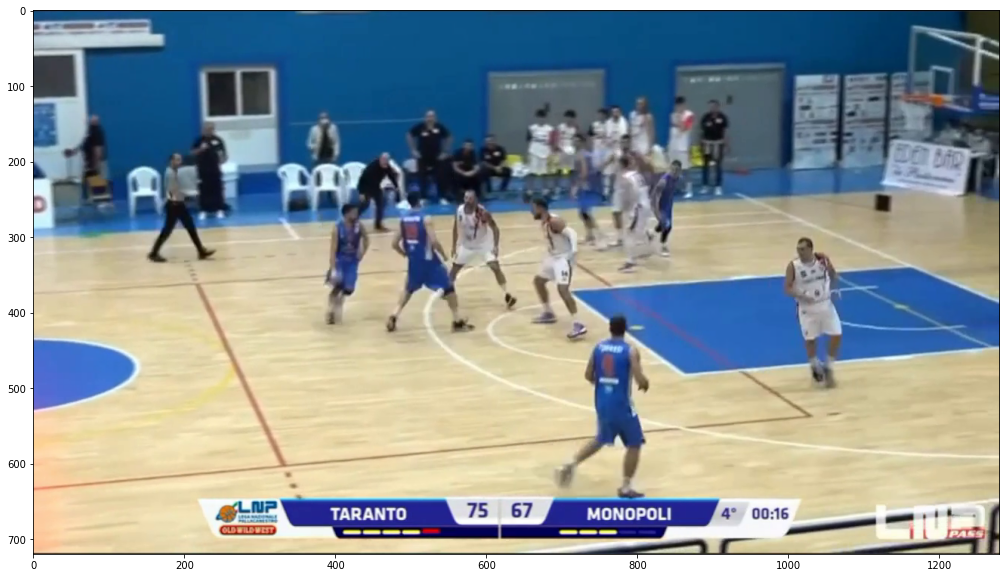

In [ ]:
#@title Show Images{ run: "auto", display-mode: "form" }
index_sample = 195  #@param {type:"slider", min:0, max:429, step:1}

imshow_tensor(ds['Small-Frames'].dataset['full'][index_sample][0])

## Cropped

I created this dataset with the help of `YoloV5` previously trailed in recognizing baskets and fed it with `Small-Frames` and other 7000 screnshoot of games precisely classified. This dataset contains remarkably small images that exactly represent the basket, so I expect performance to increase. 
  * Images size: 128x128
  * Images: 6863 (644 `Point`, 6219 `No Point`)
  * It will be divided into: train, validation, test (70, 15, 15)

### Load

In [ ]:
cr_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    transforms.Resize([128, 128])])

In [ ]:
!gdown 1myHDJejaHe65mS7IspxRXwy_2D6pLFnH
ds["Cropped"] = DatasetClass(
            extraction_path = "/content/Cropped.zip", 
            dataset_name = "Cropped", 
            train_batchsize = 256,
            eval_batchsize = 512, 
            split_dimension = [0.7, 0.15, 0.15],
            transform = cr_transform)

Downloading...
From: https://drive.google.com/uc?id=1myHDJejaHe65mS7IspxRXwy_2D6pLFnH
To: /content/Cropped.zip
100% 134M/134M [00:02<00:00, 45.2MB/s]


### Analysis

In [ ]:
print(f'Dataset Distribution \n'
      f'Number of No Point images: {ds["Cropped"].dataset["full"].targets.count(0)} \n'
      f'Number of Point images: {ds["Cropped"].dataset["full"].targets.count(1)}\n')

print(f'Split Distribution: \n'
      f'Training Set: {len(ds["Cropped"].dataset["train"])} images\n'
      f'Validation Set: {len(ds["Cropped"].dataset["val"])} images\n'
      f'Test Set: {len(ds["Cropped"].dataset["test"])} images')

Dataset Distribution 
Number of No Point images: 6219 
Number of Point images: 644

Split Distribution: 
Training Set: 4805 images
Validation Set: 1029 images
Test Set: 1029 images


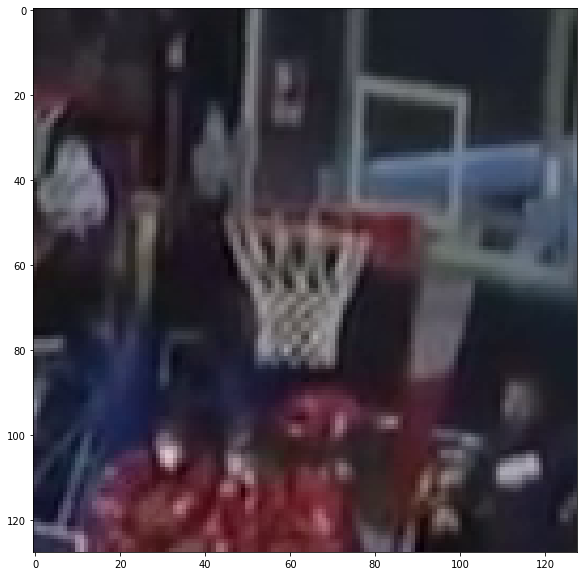

In [ ]:
#@title Show Images{ run: "auto", display-mode: "form" }
index_sample = 3985  #@param {type:"slider", min:0, max:6218, step:1}

imshow_tensor(ds['Cropped'].dataset['full'][index_sample][0])

## BasketLocalization

This dataset was created from the previous `Small-Frames`. More specifically, I created the boundingboxes around all the baskets manually for `YoloV5` to be trailed to recognize the baskets (both with ball inside and without).
  * Images size: 1280x720
  * Images: 430 (215 `Point`, 215 `No Point`)
  * It will not be divided

(I just need to extract it, then `YoloV5` will handle the import)

In [ ]:
!gdown 162JEm0cuWOE2hFMkeUk2X1MLKmTPJJ2Q

zip_dataset_path = "/content/BasketLocalization.zip"
extracted_dataset_path = "/content/"

with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dataset_path)

Downloading...
From: https://drive.google.com/uc?id=162JEm0cuWOE2hFMkeUk2X1MLKmTPJJ2Q
To: /content/BasketLocalization.zip
100% 450M/450M [00:12<00:00, 35.2MB/s]


# [Part 1] Binary classification on 1280x720 images

## Models
I will use two Models:
- **Baseline Model**: 3(Convolution Layer + Max Pooling) + GlobalMaxPooling + FC
- **ResNet50**

### Baseline Model

In [ ]:
input_size = (3, 720, 1280)
batch_size = 16

# In order to speed up the process I want to use the current device
baseline_model = BaselineModel().to(device)

summary(baseline_model, input_size = input_size, batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 6, 718, 1278]             168
         MaxPool2d-2          [16, 6, 239, 426]               0
            Conv2d-3         [16, 12, 237, 424]             660
         MaxPool2d-4          [16, 12, 79, 141]               0
            Conv2d-5          [16, 24, 77, 139]           2,616
         MaxPool2d-6           [16, 24, 25, 46]               0
 AdaptiveMaxPool2d-7             [16, 24, 1, 1]               0
            Linear-8                  [16, 128]           3,200
            Linear-9                    [16, 1]             129
          Sigmoid-10                    [16, 1]               0
Total params: 6,773
Trainable params: 6,773
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 168.75
Forward/backward pass size (MB): 944.90
Params size (MB): 0.03
Estimated T

### ResNet50

In [ ]:
resnet50 = generate_resnet50(device = device)
input_size = (3, 720, 1280)
batch_size = 8

summary(resnet50, input_size = input_size, batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 360, 640]           9,408
       BatchNorm2d-2          [8, 64, 360, 640]             128
              ReLU-3          [8, 64, 360, 640]               0
         MaxPool2d-4          [8, 64, 180, 320]               0
            Conv2d-5          [8, 64, 180, 320]           4,096
       BatchNorm2d-6          [8, 64, 180, 320]             128
              ReLU-7          [8, 64, 180, 320]               0
            Conv2d-8          [8, 64, 180, 320]          36,864
       BatchNorm2d-9          [8, 64, 180, 320]             128
             ReLU-10          [8, 64, 180, 320]               0
           Conv2d-11         [8, 256, 180, 320]          16,384
      BatchNorm2d-12         [8, 256, 180, 320]             512
           Conv2d-13         [8, 256, 180, 320]          16,384
      BatchNorm2d-14         [8, 256, 1

## Train on Small-Frames Dataset

It is advisable to initially test the models to a smaller dataset to verify that everything is working properly and that the models, despite the dataset being small, are able to learn. This is exactly what I did, this dataset in fact contains just over 500 images.

After the training, it was found that both the `baseline_model` and `resnet50` models reduced their training loss and valuation loss. We can therefore make the following statements:
* The **models are learning**, however having an accuracy around 60% (65% for the baseline and 55% for resnet50) for a binary classifier is a bad result
* The **time taken by the models for training is really long**, which was to be expected since the images introduced in the model are 1280x720 in size
* One possible explanation for the poor performance could be precisely the very large images, **the model has no idea where to "look"** to categorize the image


### Train Baseline Model

In [ ]:
lr = 0.001
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(baseline_model.parameters(), lr = lr)

early_stopper = EarlyStopper(patience = 5, min_delta = 0)
history = training_loop(num_epochs, optimizer, log_interval,
                        baseline_model,
                        ds['Small-Frames'].dataloader['train'], 
                        ds['Small-Frames'].dataloader['val'],
                        loss_func = nn.BCELoss(),
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00100000  Loss: Train = [0.6972] - Val = [0.6940]  Accuracy: Train = [46.80%] - Val = [47.67%]  Time one epoch (s): 26.1593 
Epoch: 2  Lr: 0.00100000  Loss: Train = [0.6938] - Val = [0.6934]  Accuracy: Train = [50.58%] - Val = [47.67%]  Time one epoch (s): 26.4882 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.6933] - Val = [0.6933]  Accuracy: Train = [50.58%] - Val = [47.67%]  Time one epoch (s): 24.7524 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.6932] - Val = [0.6924]  Accuracy: Train = [50.29%] - Val = [52.33%]  Time one epoch (s): 24.5304 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.6928] - Val = [0.6933]  Accuracy: Train = [52.62%] - Val = [47.67%]  Time one epoch (s): 24.9421 
Epoch: 6  Lr: 0.00100000  Loss: Train = [0.6936] - Val = [0.6916]  Accuracy: Train = [54.36%] - Val = [47.67%]  Time one epoch (s): 24.9549 
Epoch: 7  Lr: 0.00100000  Loss: Train = [0.6920] - Val = [0.6901]  Accuracy: Train = [50.58%] - Val = [53.49%]  Time one epoch (s): 25.0091 
Epoch: 8  Lr:

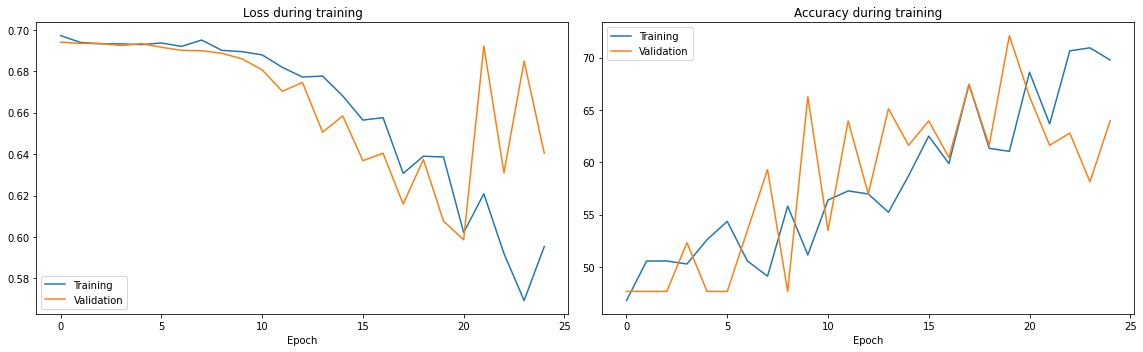

In [ ]:
display_history(history)

### Train ResNet50

In [ ]:
lr = 0.0005
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(resnet50.parameters(), lr = lr)

early_stopper = EarlyStopper(patience = 5, min_delta = 0)
history = training_loop(num_epochs, optimizer, log_interval,
                        resnet50, 
                        ds['Small-Frames'].dataloader['train'], 
                        ds['Small-Frames'].dataloader['val'],
                        loss_func = nn.BCELoss(),
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00050000  Loss: Train = [0.7813] - Val = [0.7818]  Accuracy: Train = [53.20%] - Val = [45.35%]  Time one epoch (s): 78.4111 
Epoch: 2  Lr: 0.00050000  Loss: Train = [0.6945] - Val = [0.6324]  Accuracy: Train = [52.62%] - Val = [53.49%]  Time one epoch (s): 78.8390 
Epoch: 3  Lr: 0.00050000  Loss: Train = [0.6581] - Val = [0.8553]  Accuracy: Train = [61.92%] - Val = [48.84%]  Time one epoch (s): 79.0453 
Epoch: 4  Lr: 0.00050000  Loss: Train = [0.7170] - Val = [12.0599]  Accuracy: Train = [54.07%] - Val = [50.00%]  Time one epoch (s): 79.1881 
Epoch: 5  Lr: 0.00050000  Loss: Train = [0.7024] - Val = [0.6645]  Accuracy: Train = [53.78%] - Val = [58.14%]  Time one epoch (s): 78.9135 
Epoch: 6  Lr: 0.00050000  Loss: Train = [0.7268] - Val = [0.6749]  Accuracy: Train = [53.20%] - Val = [56.98%]  Time one epoch (s): 78.9082 
--- Early Stopping ---
Time for 6 epochs (s): 552.278


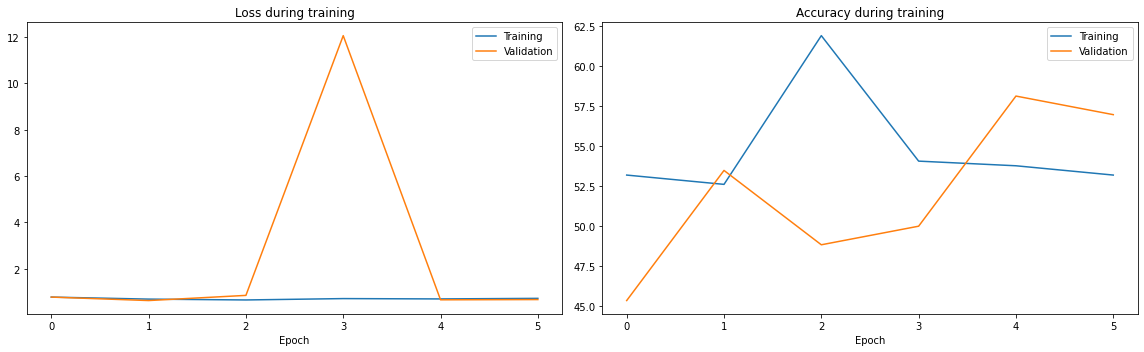

In [ ]:
display_history(history)

## Save/Load Model (Optional)

### Baseline Model

#### Save Model

In [ ]:
baseline_model_small_frames_weights_path = '/content/baseline_model Small-Frames.pth'
torch.save(baseline_model.state_dict(), baseline_model_small_frames_weights_path)

#### Load Model (Optional)

In [ ]:
!gdown 1vZ8kaWLejRiaIFihB71txzjHR5b2E7le
baseline_model_small_frames_weights_path = '/content/baseline_model Small-Frames.pth'
baseline_model.load_state_dict(torch.load(baseline_model_small_frames_weights_path))

<All keys matched successfully>

### ResNet50

#### Save Model

In [ ]:
resnet50_model_small_frames_weights_path = '/content/resnet50 Small-Frames.pth'
torch.save(resnet50.state_dict(), resnet50_model_small_frames_weights_path)

#### Load Model

In [ ]:
!gdown 1--oYw77HKIm2i3v-fTzX0eQ8AU-gMpEY
resnet50_model_small_frames_weights_path = '/content/resnet50 Small-Frames.pth'
resnet50.load_state_dict(torch.load(resnet50_model_small_frames_weights_path))

## Considerations

It does not make any sense to use the bigger dataset as this in my opinion is not the right way for one simple reason: **the images are too large and the models do not know where to look**. I decided to avoid doing the evaluation as I felt the performance of the models was too low.



#[Part 2] Binary classification on 128x128 images

## Models
I will use two Models (same as before):
- **Baseline Model**: 3(Convolution Layer + Max Pooling) + FC
- **ResNet50**
- **ResNet50** pretrained and compute fine-tuning

### Baseline Model

In [ ]:
input_size = (3, 720, 1280)
batch_size = 16

# In order to speed up the process I want to use the current device
baseline_model = BaselineModel().to(device)

summary(baseline_model, input_size = input_size, batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 6, 718, 1278]             168
         MaxPool2d-2          [16, 6, 239, 426]               0
            Conv2d-3         [16, 12, 237, 424]             660
         MaxPool2d-4          [16, 12, 79, 141]               0
            Conv2d-5          [16, 24, 77, 139]           2,616
         MaxPool2d-6           [16, 24, 25, 46]               0
 AdaptiveMaxPool2d-7             [16, 24, 1, 1]               0
            Linear-8                  [16, 128]           3,200
            Linear-9                    [16, 1]             129
          Sigmoid-10                    [16, 1]               0
Total params: 6,773
Trainable params: 6,773
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 168.75
Forward/backward pass size (MB): 944.90
Params size (MB): 0.03
Estimated T

### ResNet50

In [ ]:
resnet50 = generate_resnet50(device = device)
input_size = (3, 720, 1280)
batch_size = 8

summary(resnet50, input_size = input_size, batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 360, 640]           9,408
       BatchNorm2d-2          [8, 64, 360, 640]             128
              ReLU-3          [8, 64, 360, 640]               0
         MaxPool2d-4          [8, 64, 180, 320]               0
            Conv2d-5          [8, 64, 180, 320]           4,096
       BatchNorm2d-6          [8, 64, 180, 320]             128
              ReLU-7          [8, 64, 180, 320]               0
            Conv2d-8          [8, 64, 180, 320]          36,864
       BatchNorm2d-9          [8, 64, 180, 320]             128
             ReLU-10          [8, 64, 180, 320]               0
           Conv2d-11         [8, 256, 180, 320]          16,384
      BatchNorm2d-12         [8, 256, 180, 320]             512
           Conv2d-13         [8, 256, 180, 320]          16,384
      BatchNorm2d-14         [8, 256, 1

### ResNet50 (Fine Tuning)

In [ ]:
resnet50_ft = generate_resnet50(pretrained = True, device = device)
input_size = (3, 720, 1280)
batch_size = 8

summary(resnet50_ft, input_size = input_size, batch_size = batch_size)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 360, 640]           9,408
       BatchNorm2d-2          [8, 64, 360, 640]             128
              ReLU-3          [8, 64, 360, 640]               0
         MaxPool2d-4          [8, 64, 180, 320]               0
            Conv2d-5          [8, 64, 180, 320]           4,096
       BatchNorm2d-6          [8, 64, 180, 320]             128
              ReLU-7          [8, 64, 180, 320]               0
            Conv2d-8          [8, 64, 180, 320]          36,864
       BatchNorm2d-9          [8, 64, 180, 320]             128
             ReLU-10          [8, 64, 180, 320]               0
           Conv2d-11         [8, 256, 180, 320]          16,384
      BatchNorm2d-12         [8, 256, 180, 320]             512
           Conv2d-13         [8, 256, 180, 320]          16,384
      BatchNorm2d-14         [8, 256, 1

## Train on Cropped Dataset

Notice that the performance did not magically rise, we start from 90% accuracy since i notice that the baseline model initially tends to assign almost always 0 (`no-point`) plus the dataset contain 90% of the images labeled as `no-point` and 10% are labeled as `point`. That being said, we can see that notwithstanding this "false start" the model is still learning by reducing both training loss and validation loss.

Summarizing the results obtained, we have:
* For the `baseline model` accuracies little greater than 0.9 which means that it performs little better than a model that always assigns `no-point`.
* For the two `resnet50` models, on the other hand, the accuracy obtained is around 0.95 which is definitely a better result than the previous one.

### Train Baseline Model

In [ ]:
lr = 0.001
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(baseline_model.parameters(), lr = lr)

early_stopper = EarlyStopper(patience = 5, min_delta = 0)
history = training_loop(num_epochs, optimizer, log_interval,
                        baseline_model, 
                        ds['Cropped'].dataloader['train'], 
                        ds['Cropped'].dataloader['train'],
                        loss_func = nn.BCELoss(),
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00100000  Loss: Train = [0.6594] - Val = [0.5080]  Accuracy: Train = [60.27%] - Val = [90.11%]  Time one epoch (s): 12.5788 
Epoch: 2  Lr: 0.00100000  Loss: Train = [0.3794] - Val = [0.3501]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 12.3106 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.3376] - Val = [0.3302]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 12.2079 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.3310] - Val = [0.3296]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 12.3396 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.3292] - Val = [0.3274]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 12.2920 
Epoch: 6  Lr: 0.00100000  Loss: Train = [0.3271] - Val = [0.3272]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 12.3396 
Epoch: 7  Lr: 0.00100000  Loss: Train = [0.3271] - Val = [0.3264]  Accuracy: Train = [90.11%] - Val = [90.11%]  Time one epoch (s): 14.8529 
Epoch: 8  Lr:

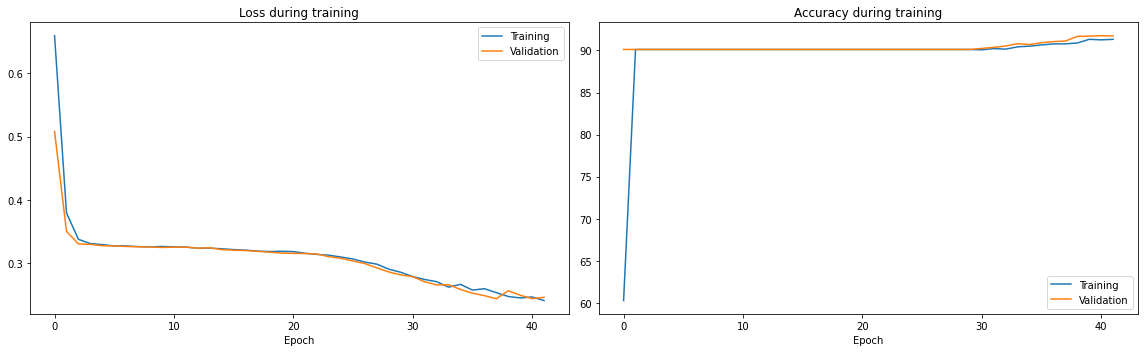

In [ ]:
display_history(history)

### Train ResNet50

In [ ]:
lr = 0.001
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(resnet50.parameters(), lr = lr)

early_stopper = EarlyStopper(patience = 5, min_delta = 0)
history = training_loop(num_epochs, optimizer, log_interval,
                        resnet50, 
                        ds['Cropped'].dataloader['train'],
                        ds['Cropped'].dataloader['val'], 
                        loss_func = nn.BCELoss(),
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00100000  Loss: Train = [0.4620] - Val = [0.3090]  Accuracy: Train = [88.55%] - Val = [91.25%]  Time one epoch (s): 20.5954 
Epoch: 2  Lr: 0.00100000  Loss: Train = [0.3985] - Val = [0.5839]  Accuracy: Train = [90.07%] - Val = [91.25%]  Time one epoch (s): 20.9137 
Epoch: 3  Lr: 0.00100000  Loss: Train = [0.3752] - Val = [0.2676]  Accuracy: Train = [90.09%] - Val = [91.25%]  Time one epoch (s): 21.2551 
Epoch: 4  Lr: 0.00100000  Loss: Train = [0.2814] - Val = [0.3052]  Accuracy: Train = [90.72%] - Val = [90.38%]  Time one epoch (s): 20.8841 
Epoch: 5  Lr: 0.00100000  Loss: Train = [0.2607] - Val = [0.3350]  Accuracy: Train = [91.36%] - Val = [90.57%]  Time one epoch (s): 20.7773 
Epoch: 6  Lr: 0.00100000  Loss: Train = [0.2385] - Val = [0.2798]  Accuracy: Train = [91.57%] - Val = [90.67%]  Time one epoch (s): 20.9537 
Epoch: 7  Lr: 0.00100000  Loss: Train = [0.2060] - Val = [0.2448]  Accuracy: Train = [93.32%] - Val = [92.32%]  Time one epoch (s): 20.9108 
Epoch: 8  Lr:

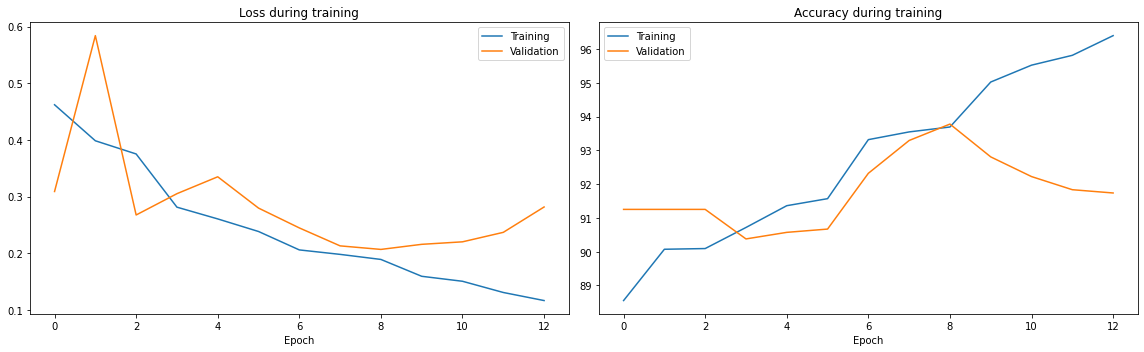

In [ ]:
display_history(history)

### Train ResNet50 (Fine Tuning)

In [ ]:
lr = 0.0001
num_epochs = 500
log_interval = 20

optimizer = torch.optim.Adam(resnet50_ft.parameters(), lr = lr)

early_stopper = EarlyStopper(patience = 3, min_delta = 0)
history = training_loop(num_epochs, optimizer, log_interval,
                        resnet50_ft, 
                        ds['Cropped'].dataloader['train'],
                        ds['Cropped'].dataloader['val'], 
                        loss_func = nn.BCELoss(),
                        early_stopping = early_stopper)

Epoch: 1  Lr: 0.00010000  Loss: Train = [0.4270] - Val = [0.3025]  Accuracy: Train = [86.10%] - Val = [91.25%]  Time one epoch (s): 20.8580 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.2042] - Val = [0.1942]  Accuracy: Train = [90.57%] - Val = [92.23%]  Time one epoch (s): 20.8915 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.1346] - Val = [0.1456]  Accuracy: Train = [94.17%] - Val = [94.56%]  Time one epoch (s): 20.8367 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.0665] - Val = [0.1636]  Accuracy: Train = [97.86%] - Val = [94.66%]  Time one epoch (s): 20.7657 
Epoch: 5  Lr: 0.00010000  Loss: Train = [0.0400] - Val = [0.1296]  Accuracy: Train = [98.86%] - Val = [95.92%]  Time one epoch (s): 20.7763 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.0248] - Val = [0.1568]  Accuracy: Train = [99.27%] - Val = [95.24%]  Time one epoch (s): 20.8480 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.0136] - Val = [0.1523]  Accuracy: Train = [99.69%] - Val = [96.70%]  Time one epoch (s): 20.7943 
--- Early Sto

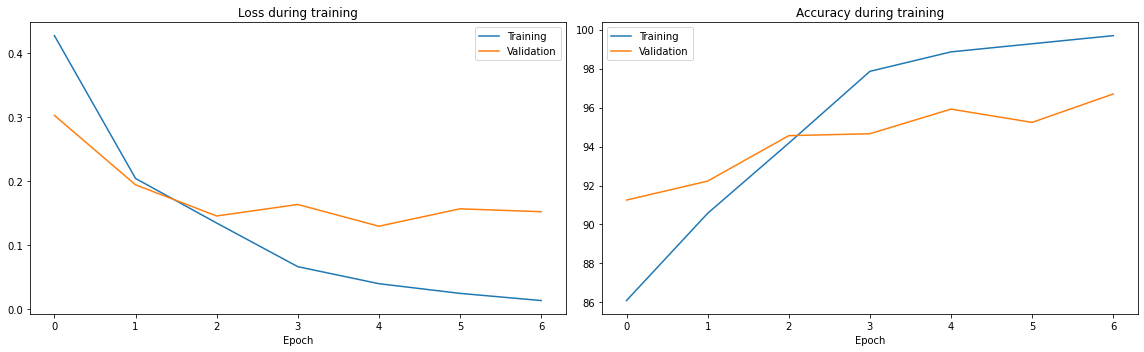

In [ ]:
display_history(history)

## Save/Load Model (Optional)

### Baseline Model

#### Save Model

In [ ]:
baseline_model_cropped_weights_path = '/content/baseline_model Cropped.pth'
torch.save(baseline_model.state_dict(), baseline_model_cropped_weights_path)

#### Load Model (Optional)

In [ ]:
!gdown 1-CwSZpISxn5E6nA_rjDZqeRyliuqEl-A
baseline_model_cropped_weights_path = '/content/baseline_model Cropped.pth'
baseline_model.load_state_dict(torch.load(baseline_model_cropped_weights_path))

Downloading...
From: https://drive.google.com/uc?id=1-CwSZpISxn5E6nA_rjDZqeRyliuqEl-A
To: /content/baseline_model Cropped.pth
100% 30.7k/30.7k [00:00<00:00, 45.7MB/s]


<All keys matched successfully>

### ResNet50

#### Save Model

In [ ]:
resnet50_model_cropped_weights_path = '/content/resnet50 Cropped.pth'
torch.save(resnet50.state_dict(), resnet50_model_cropped_weights_path)

#### Load Model

In [ ]:
!gdown 1-DFR1P1hooQL8gzGmkmr5wzBMjcGwjh5
resnet50_model_cropped_weights_path = '/content/resnet50 Cropped.pth'
resnet50.load_state_dict(torch.load(resnet50_model_cropped_weights_path))

Downloading...
From: https://drive.google.com/uc?id=1-DFR1P1hooQL8gzGmkmr5wzBMjcGwjh5
To: /content/resnet50 Cropped.pth
100% 94.4M/94.4M [00:02<00:00, 32.0MB/s]


<All keys matched successfully>

### ResNet50 (Fine Tuned)

#### Save Model

In [ ]:
resnet50_ft_model_cropped_weights_path = '/content/resnet50_ft Cropped.pth'
torch.save(resnet50_ft.state_dict(), resnet50_ft_model_cropped_weights_path)

#### Load Model

In [ ]:
!gdown 1DU0Z0iRv73idQSmRU5aZPjQQGrjZ8he1
resnet50_ft_model_cropped_weights_path = '/content/resnet50_ft Cropped.pth'
resnet50_ft.load_state_dict(torch.load(resnet50_ft_model_cropped_weights_path))

Downloading...
From: https://drive.google.com/uc?id=1DU0Z0iRv73idQSmRU5aZPjQQGrjZ8he1
To: /content/resnet50_ft Cropped.pth
100% 94.4M/94.4M [00:00<00:00, 164MB/s]


<All keys matched successfully>

## Evaluation (Test Set)

Summarizing the results obtained on the test set we have that:
* `Baseline Model`: it has an F1 Score of 0.64 and an Accuracy of 0.92
* `ResNet50`: it has an F1 Score of 0.718 and an Accuracy of 0.93
* `ResNet50 (FineTuned)`: it has an F1 Score of 0.834 and an Accuracy of 0.954

These results confirmed the precedents obtained on the validation set. Also as we can see the best model is `ResNet50 (Finetuned)` which then will be used for the next Part. Another thing we can notice in the confusion matrix is that the model has difficulty classifying some `points`. In fact, it often happens that it misclassifies a `point` as a `non-point` than vice versa. I hope, however, that when we go to analyze the video this model will have more "attempts" to identify a possible `point` and not a single frame, so the performance will be better.

### Baseline Model

In [ ]:
baseline_model_results = get_predictions(baseline_model, ds['Cropped'].dataloader['test'])
baseline_model_f1 = f1_score(baseline_model_results['true'], baseline_model_results['predictions'], average='macro')
baseline_model_acc = accuracy_score(baseline_model_results['true'], baseline_model_results['predictions'])
print(f"Baseline Model\n" 
      f"F1 Score: [{round(baseline_model_f1, 3)}] - Accuracy:[{round(baseline_model_acc, 3)}]\n")

Baseline Model
F1 Score: [0.64] - Accuracy:[0.915]



Confidence: [0.474] Predict: [0], True value: [0]


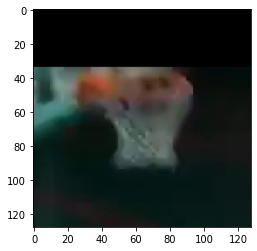

In [ ]:
#@title Show Answers - Baseline Model { run: "auto", display-mode: "form" }
index_sample = 946  #@param {type:"slider", min:0, max:1028, step:1}

img_to_show = ds['Cropped'].dataset['test'][index_sample][0]
confidence_value = baseline_model_results['confidence'][index_sample]
pred_value = baseline_model_results['predictions'][index_sample]
true_value = baseline_model_results['true'][index_sample]
print(f"Confidence: [{round(confidence_value, 3)}] Predict: [{pred_value}], True value: [{true_value}]")
imshow_tensor(img_to_show)

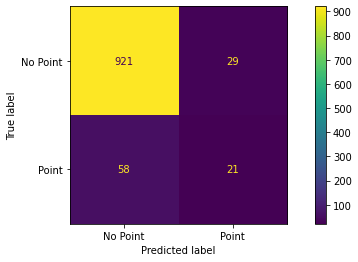

In [ ]:
cm = confusion_matrix(baseline_model_results['true'], baseline_model_results['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Point', 'Point'])
disp.plot()

### Resnet50

In [ ]:
resnet50_results = get_predictions(resnet50, ds['Cropped'].dataloader['test'])
resnet50_f1 = f1_score(resnet50_results['true'], resnet50_results['predictions'], average='macro')
resnet50_acc = accuracy_score(resnet50_results['true'], resnet50_results['predictions'])
print(f"Resnet50\n" 
      f"F1 Score: [{round(resnet50_f1, 3)}] - Accuracy:[{round(resnet50_acc, 3)}]\n")

Resnet50
F1 Score: [0.718] - Accuracy:[0.929]



Confidence: [0.002] Predict: [0], True value: [0]


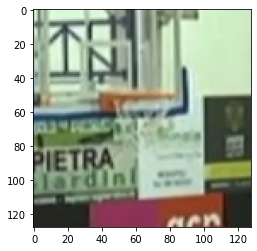

In [ ]:
#@title Show Answers - Resnet50 { run: "auto", display-mode: "form" }
index_sample = 342  #@param {type:"slider", min:0, max:1028, step:1}

img_to_show = ds['Cropped'].dataset['test'][index_sample][0]
confidence_value = resnet50_results['confidence'][index_sample]
pred_value = resnet50_results['predictions'][index_sample]
true_value = resnet50_results['true'][index_sample]
print(f"Confidence: [{round(confidence_value, 3)}] Predict: [{pred_value}], True value: [{true_value}]")
imshow_tensor(img_to_show)

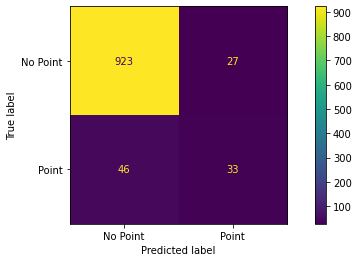

In [ ]:
cm = confusion_matrix(resnet50_results['true'], resnet50_results['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Point', 'Point'])
disp.plot()

### Resnet50 Fine Tuned

In [ ]:
resnet50_ft_results = get_predictions(resnet50_ft, ds['Cropped'].dataloader['test'])
resnet50_ft_f1 = f1_score(resnet50_ft_results['true'], resnet50_ft_results['predictions'], average='macro')
resnet50_ft_acc = accuracy_score(resnet50_ft_results['true'], resnet50_ft_results['predictions'])
print(f"Resnet50 Fine Tuned\n" 
      f"F1 Score: [{round(resnet50_ft_f1, 3)}] - Accuracy:[{round(resnet50_ft_acc, 3)}]\n")

Resnet50 Fine Tuned
F1 Score: [0.834] - Accuracy:[0.954]



Confidence: [1.0] Predict: [1], True value: [1]


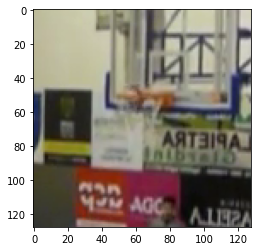

In [ ]:
#@title Show Answers - Resnet50 Fine Tuned { run: "auto", display-mode: "form" }
index_sample = 448  #@param {type:"slider", min:0, max:1028, step:1}

img_to_show = ds['Cropped'].dataset['test'][index_sample][0]
confidence_value = resnet50_ft_results['confidence'][index_sample]
pred_value = resnet50_ft_results['predictions'][index_sample]
true_value = resnet50_ft_results['true'][index_sample]
print(f"Confidence: [{round(confidence_value, 3)}] Predict: [{pred_value}], True value: [{true_value}]")
imshow_tensor(img_to_show)

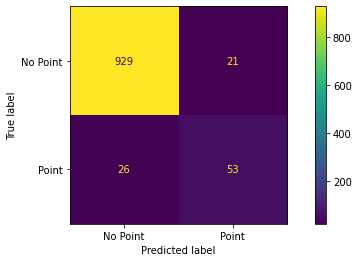

In [ ]:
cm = confusion_matrix(resnet50_ft_results['true'], resnet50_ft_results['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Point', 'Point'])
disp.plot()

#[Part 3] Basket Localization and binary classification on 128x128 images

##[Part 3.1] Train YoloV5 to Recognize baskets

### Model
I chose `YoloV5 small` as the object detection model (small because I think it is a fairly simple task to do, so even the small model should be able to do it)

#### YoloV5


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 14995, done.
remote: Total 14995 (delta 0), reused 0 (delta 0), pack-reused 14995
Receiving objects: 100% (14995/14995), 14.07 MiB | 2.34 MiB/s, done.
Resolving deltas: 100% (10286/10286), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.7 MB/s eta 0:00:00
/content


### Train

Unfortunately, I do not have a larger dataset available to conduct a study of yolo performance. Thus, I decided to use the entire dataset of 430 images to perform fine tuning on yolo for a predetermined number of epochs (50).

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 64 --epochs 50 --data /content/BasketLocalization/dataset.yaml --weights yolov5s.pt --device 0

train: weights=yolov5s.pt, cfg=, data=/content/BasketLocalization/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-69-g3b6e27a Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gam

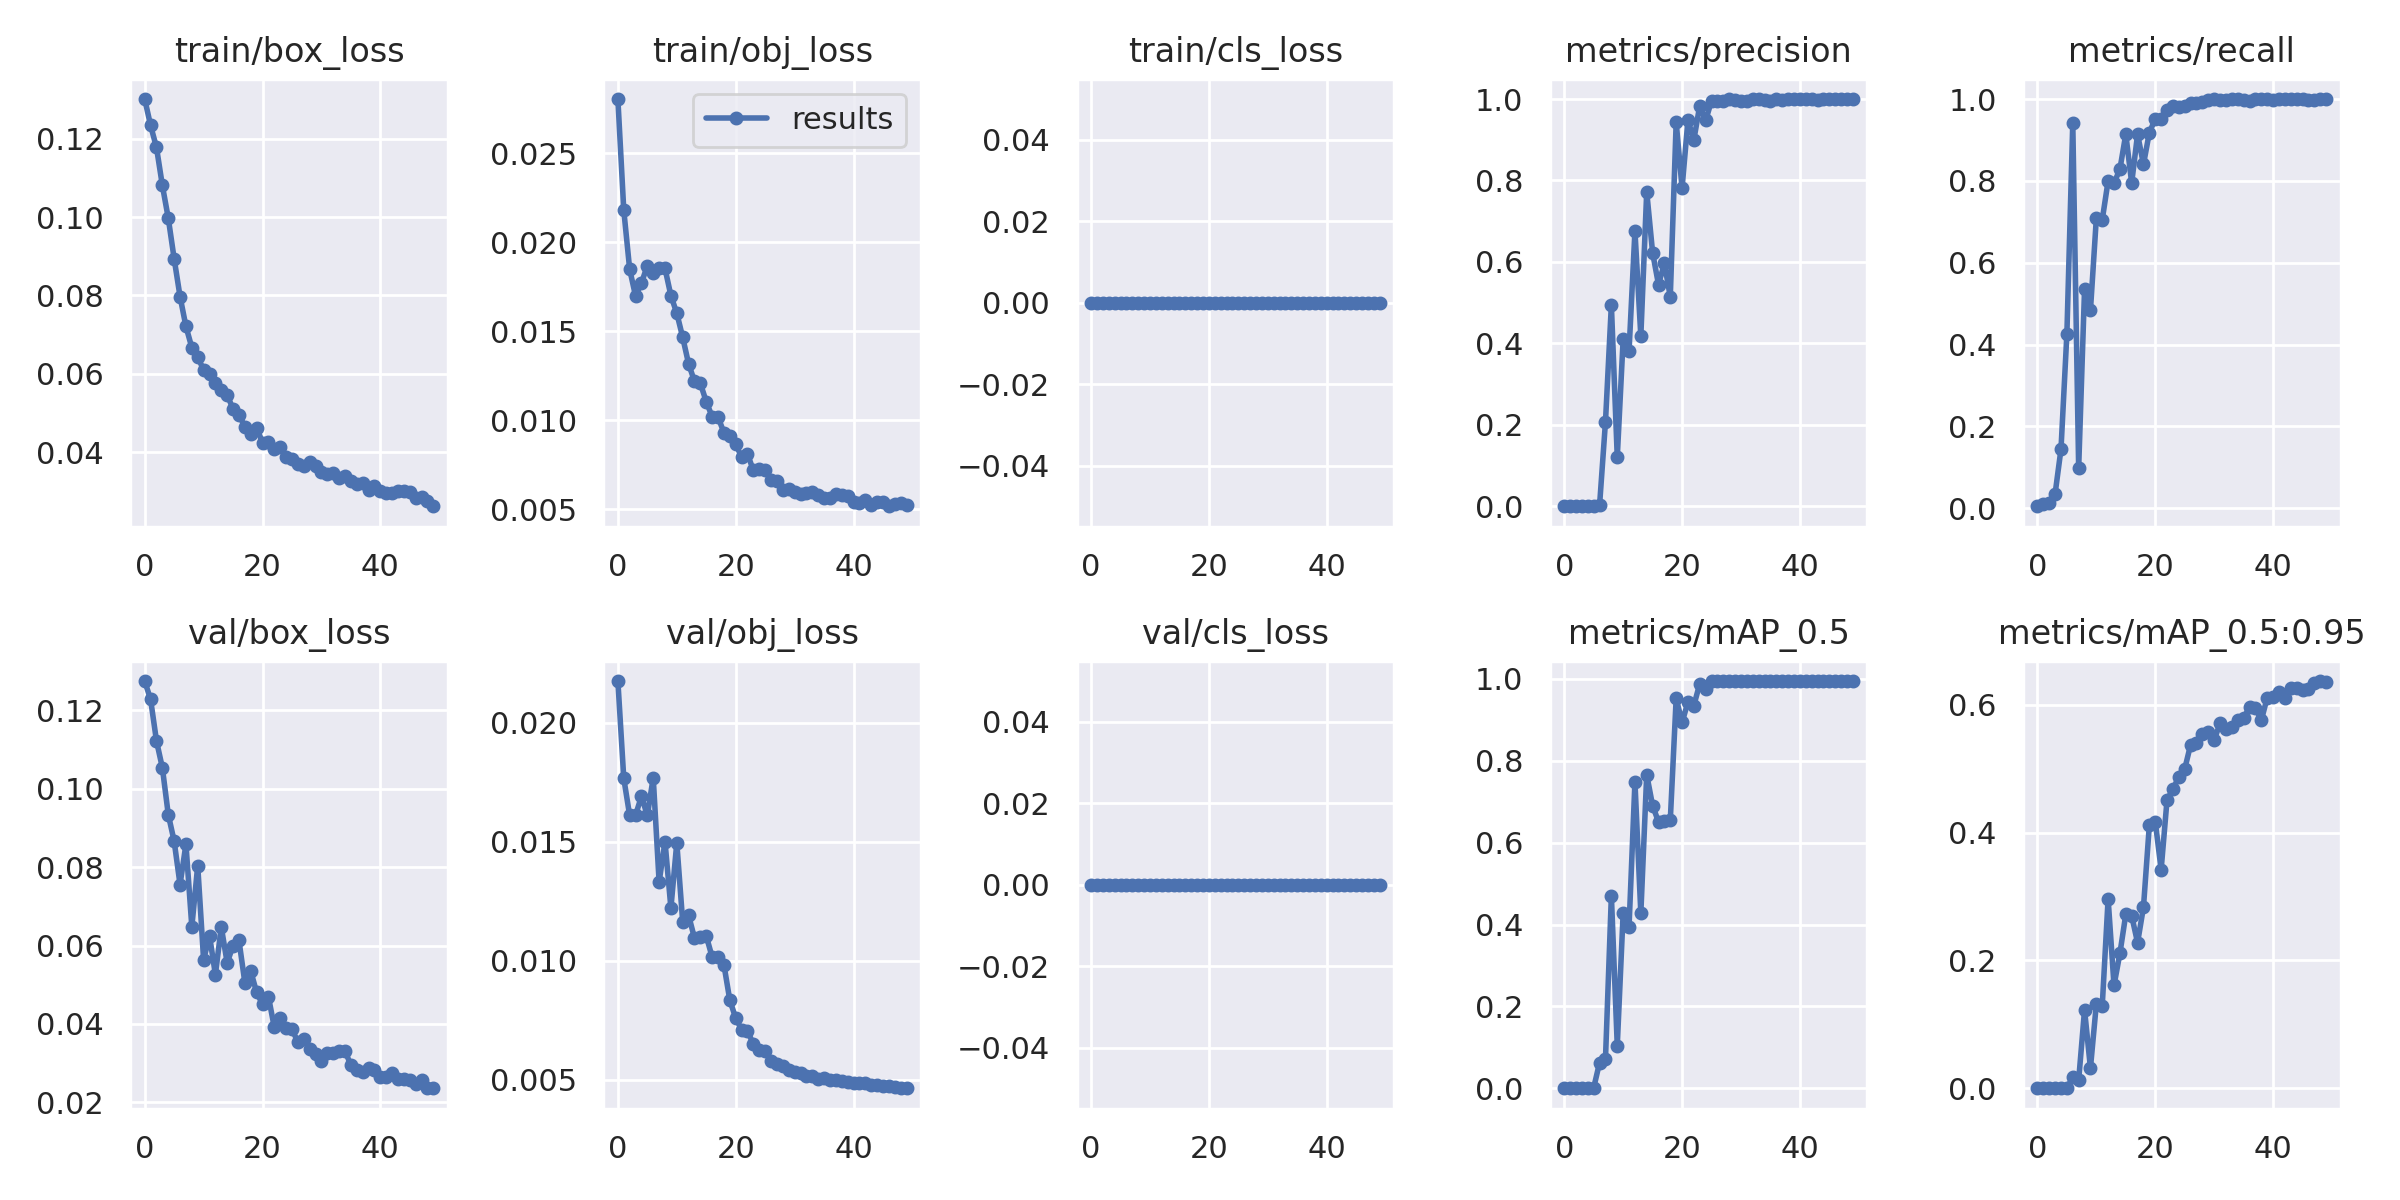

In [ ]:
im = Image.open('/content/yolov5/runs/train/exp/results.png')
im

###Save/Load Model (Optional)

#### Save

In [ ]:
!cp /content/yolov5/runs/train/exp/weights/best.pt /content/

#### Load

In [ ]:
!gdown 1HkqWTRpLvD-peNKF3iG_k2rQAubBZYdY
yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt', force_reload=True)

Downloading...
From: https://drive.google.com/uc?id=1HkqWTRpLvD-peNKF3iG_k2rQAubBZYdY
To: /content/best.pt
100% 14.3M/14.3M [00:00<00:00, 74.5MB/s]


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB

### Yolo Evaluation

Since I did not have a well-stocked dataset I had to adapt. To make this Evaluation, I took 488 screenshots of some games to verify that the model was working correctly.

In [ ]:
!gdown 1Cgy-FyYYzGWEQ8o0sIs5dkVWaHXmzWT8

zip_dataset_path = "/content/YoloTest.zip"
extracted_dataset_path = "/content/"

with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dataset_path)

Downloading...
From: https://drive.google.com/uc?id=1Cgy-FyYYzGWEQ8o0sIs5dkVWaHXmzWT8
To: /content/YoloTest.zip
100% 574M/574M [00:13<00:00, 42.0MB/s]


In [ ]:
test_yolo = glob.glob('YoloTest/*.png')

image 1/1: 720x1280 1 basket
Speed: 9.2ms pre-process, 26.5ms inference, 2.1ms NMS per image at shape (1, 3, 384, 640)


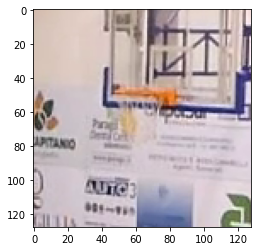

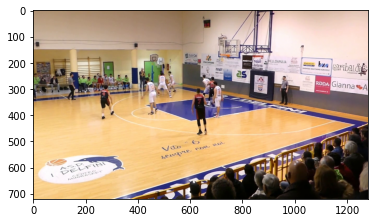

In [ ]:
#@title Show Answers - Yolo Cropping { run: "auto", display-mode: "form" }
index_sample = 29  #@param {type:"slider", min:0, max:487, step:1}

%matplotlib inline

#Get Image from dataset
img = Image.open(test_yolo[index_sample])
np_img = np.array(img)

#Inference
y_result = yolov5(img, size = 640)
print(y_result)

#if there is a basket in the image, I can go on 
#otherwise i can return confidence equal to zero
if basket_found(y_result):

  #Obtain the center of the bounding box
  x, y = bb_center(y_result)

  #Cropping the frame
  crop_frame = np_img[y-64:y+64, x-64:x+64, :]

  plt.imshow(crop_frame)
  plt.show()
  plt.imshow(np_img)

else:
  plt.imshow(np_img)
  plt.show()

##[Part 3.2] Create the YoloV5+Resnet50 model and test it on videos

### Load Models

In [ ]:
#Resnet50 Fine Tuned
!gdown 1DU0Z0iRv73idQSmRU5aZPjQQGrjZ8he1
resnet50_ft_model_cropped_weights_path = '/content/resnet50_ft Cropped.pth'
resnet50_ft = generate_resnet50(device = device)
resnet50_ft.load_state_dict(torch.load(resnet50_ft_model_cropped_weights_path, map_location=device))
resnet50_ft.eval()

#YoloV5
!gdown 1HkqWTRpLvD-peNKF3iG_k2rQAubBZYdY
yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt', force_reload=True).to(device)

Downloading...
From: https://drive.google.com/uc?id=1DU0Z0iRv73idQSmRU5aZPjQQGrjZ8he1
To: /content/resnet50_ft Cropped.pth
100% 94.4M/94.4M [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HkqWTRpLvD-peNKF3iG_k2rQAubBZYdY
To: /content/best.pt
100% 14.3M/14.3M [00:00<00:00, 44.3MB/s]


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB

### Test YoloV5+Resnet50 on a Tiny clip (~ 7s)

Before giving a 4Gb video, I thought it useful to go step by step. I therefore chose to use a 7-second clip with a `point` inside to get confirmation that `YoloV5` and `ResNet50` (Finetuned) were working properly. The point is between the 4th and 5th seconds of the clip. As can be seen from the graph, the model found the `point` correctly.

In [ ]:
#Download the video of the game (~ 1Mb)
!gdown 1uHkdRP8WvVQIny0y5t6OHREhId5euzZ7
video_path = "/content/clip-11.mp4"

frame_per_second = 60

Downloading...
From: https://drive.google.com/uc?id=1uHkdRP8WvVQIny0y5t6OHREhId5euzZ7
To: /content/clip-11.mp4
100% 1.89M/1.89M [00:00<00:00, 183MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    )])

frame_confidence = []

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with torch.no_grad():
  for i in tqdm(range(total_frames)):

    ret, frame = cap.read()
    
    #This try is useful since sometimes the shape of the bounding box is too small
    try:
      result = yolov5resnet50_pipeline(frame, transform, yolov5, resnet50_ft)
      frame_confidence.append(result)

    #Calculated padded input size per channel: (6 x 134). Kernel size: (7 x 7). 
    #Kernel size can't be greater than actual input size
    except RuntimeError:
      frame_confidence.append(0)
    
cap.release()

100%|██████████| 420/420 [00:19<00:00, 21.57it/s]


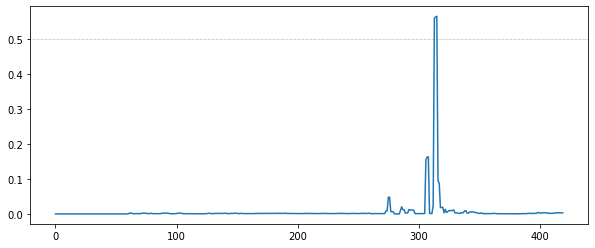

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,4)

plot_frames_points(frame_confidence)

### Test YoloV5+Resnet50 on a portion of a Match (~ 20m)

I'll use this game (25 fps): **Monopoli - Roseto** (First Quarter), Italian Basketball Serie B, Giornata 15

📊 Statistics of the game: [legapallacanestro](https://www.legapallacanestro.com/wp/match/ita3_d_2210/ita3_d/x2223)

---

After seeing that on images individually the combination of YoloV5 + Resnet50 works correctly, it was time to perform a real test on a clip of a basketball game (the first quarter, around 20 minutes). I manually annotated the baskets in a .txt file and will compare the model results with them. Also since the points are in the range of tens, I thought it will be quicker to make findings on performance manually.

As we can see from the graph represented below, the model seems to have a decent performance, in particular:

* **True Positive**: 12
* **False Positive**: 8
* **True Negative**: 68334
* **False Negative**: 2

About metrics we have:

* **Recall**: 12/14 = 0.86
* **Precision**: 12/20 = 0.60
* **F1 Score** = 0.71

In addition, by better analyzing the video at the critical points (false positives and false negatives), I noticed (understandably) that:

* Usually the model misclassifies frames as `point` when the ball is near the basket or the net is deformed (e.g. by a missed shot)
* Typically, some three-pointers are very precise and the ball has a very fast trajectory that almost imperceptibly deforms the net, making the ball appear very distorted. Furthermore, there are fewer "attempts" to guess the basket because compared to other shots, the three-pointer is associated with fewer frames. For this reason, the model struggles to classify some three-pointers as `point`.


In [ ]:
#Download the video of the game (~ 900Mb)
!gdown 1N1ijSf5u4Xq1v9myOhJx_PWIu6O6F-8W
video_path = "/content/Q1.mp4"

#Download the .txt with minutes of points
!gdown 1THnTueM2Ai1lQcpqdqzNC1axNXPOVd4C
points_path = "/content/Q1.txt"

frame_per_second = 60

Downloading...
From: https://drive.google.com/uc?id=1N1ijSf5u4Xq1v9myOhJx_PWIu6O6F-8W
To: /content/Q1.mp4
100% 916M/916M [00:07<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1THnTueM2Ai1lQcpqdqzNC1axNXPOVd4C
To: /content/Q1.txt
100% 71.0/71.0 [00:00<00:00, 125kB/s]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    )])

frame_confidence = []

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with torch.no_grad():
  for i in tqdm(range(total_frames)):

    ret, frame = cap.read()
    
    #This try is useful since sometimes the shape of the bounding box is too small
    try:
      result = yolov5resnet50_pipeline(frame, transform, yolov5, resnet50_ft)
      frame_confidence.append(result)

    #Calculated padded input size per channel: (6 x 134). Kernel size: (7 x 7). 
    #Kernel size can't be greater than actual input size
    except RuntimeError:
      frame_confidence.append(0)
    
cap.release()

100%|██████████| 68356/68356 [32:39<00:00, 34.89it/s]


In [ ]:
hms = read_from_text(points_path).split(" ")

#Approximately the point is around this frame
frame_number = [hms_to_s(x) * frame_per_second for x in hms]

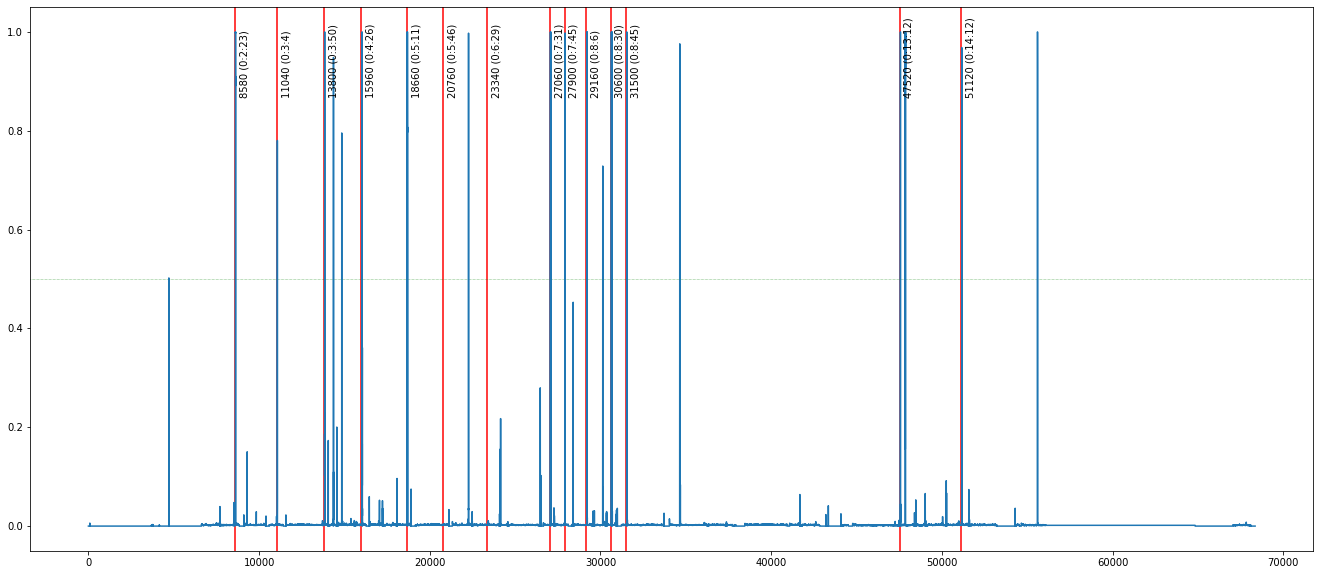

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (23,10)

plot_frames_points(frame_confidence, frame_number)

#[Final Part] Evaluation and Highlights generation

## Load Models

In [ ]:
#Resnet50 Fine Tuned
!gdown 1DU0Z0iRv73idQSmRU5aZPjQQGrjZ8he1
resnet50_ft_model_cropped_weights_path = '/content/resnet50_ft Cropped.pth'
resnet50_ft = generate_resnet50(device = device)
resnet50_ft.load_state_dict(torch.load(resnet50_ft_model_cropped_weights_path, map_location=device))
resnet50_ft.eval()

#YoloV5
!gdown 1HkqWTRpLvD-peNKF3iG_k2rQAubBZYdY
yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/best.pt', force_reload=True).to(device)

## Inference on Match video [1+ hour with GPU]
I chose this video for two main reasons:
* It does not feature the team I work for, so it is played on a different court than usual and I want to see how the model performs having seen few baskets from this court
* The cameraman for this game uses different zooms when a player makes a basket, so I would like to test the scale invariance of the model

---

I'll use this game (25 fps): **Bisceglie-Avellino**, Italian Basketball Serie B, Giornata 15

📊 Statistics of the game: [legapallacanestro](https://www.legapallacanestro.com/wp/match/ita3_d_2217/ita3_d/x2223)

In [ ]:
#Download the video of the game (~ 4.8Gb)
!gdown 1C22tXmjq_dgQjEm7btSg9q8b7_5diFYU
video_path = "/content/match.mp4"

#Download the .txt with minutes of points
!gdown 1vxTnA9z8sTBylNNVOlr1p6XraCXsw-Jm
points_path = '/content/match.txt'

frame_per_second = 25

Downloading...
From: https://drive.google.com/uc?id=1C22tXmjq_dgQjEm7btSg9q8b7_5diFYU
To: /content/match.mp4
100% 4.81G/4.81G [00:42<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vxTnA9z8sTBylNNVOlr1p6XraCXsw-Jm
To: /content/match.txt
100% 473/473 [00:00<00:00, 1.06MB/s]


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    )])

frame_confidence = []

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with torch.no_grad():
  for i in tqdm(range(total_frames)):

    ret, frame = cap.read()
    
    #This try is useful since sometimes the shape of the bounding box is too small
    try:
      result = yolov5resnet50_pipeline(frame, transform, yolov5, resnet50_ft)
      frame_confidence.append(result)

    #Calculated padded input size per channel: (6 x 134). Kernel size: (7 x 7). 
    #Kernel size can't be greater than actual input size
    except RuntimeError:
      frame_confidence.append(0)
    
cap.release()

100%|██████████| 186641/186641 [1:27:30<00:00, 35.55it/s]


## Evaluation of the model

While studying the results, I noticed how the model was anomalous in some parts of the movie (see graph below). I am talking about the early part of the match and the middle part. However in those instants the players usually shoot at the basket to warm up so that abnormal behavior is justified. I decided later to eliminate those parts so as not to modify the results.

Synthesizing the results:
* The model **found 451 total points** (Many of these during the warm-up). I was able to find the baskets by calculating the peaks on the graph below using `signal.find_peaks(frame_confidence, height=.5, distance = frame_tollerance)`. In other words, I wanted maximums of at least `0.5` (threshold) to be found and to have a distance between them of at least `frame_tollerance` (this is to prevent detection of the same basket multiple times).
* After eliminating hoop shots during hooping we were **left with only 146 points**.

But will they all be correctly detected points? Obviously not:
* Points found correctly (True Positive): 64
* Points not found (False Negative): 2
* Missclassified Points found (False Positive): 82

In terms of metrics we have (which coincide with the results of the previous test):
* Precision: 0.44
* Recall: 0.97
* F1 Score: 0.60

In [ ]:
hms = read_from_text(points_path).split(" ")

#Approximately the point is around this frame
true_frame = [hms_to_s(x) * frame_per_second for x in hms]

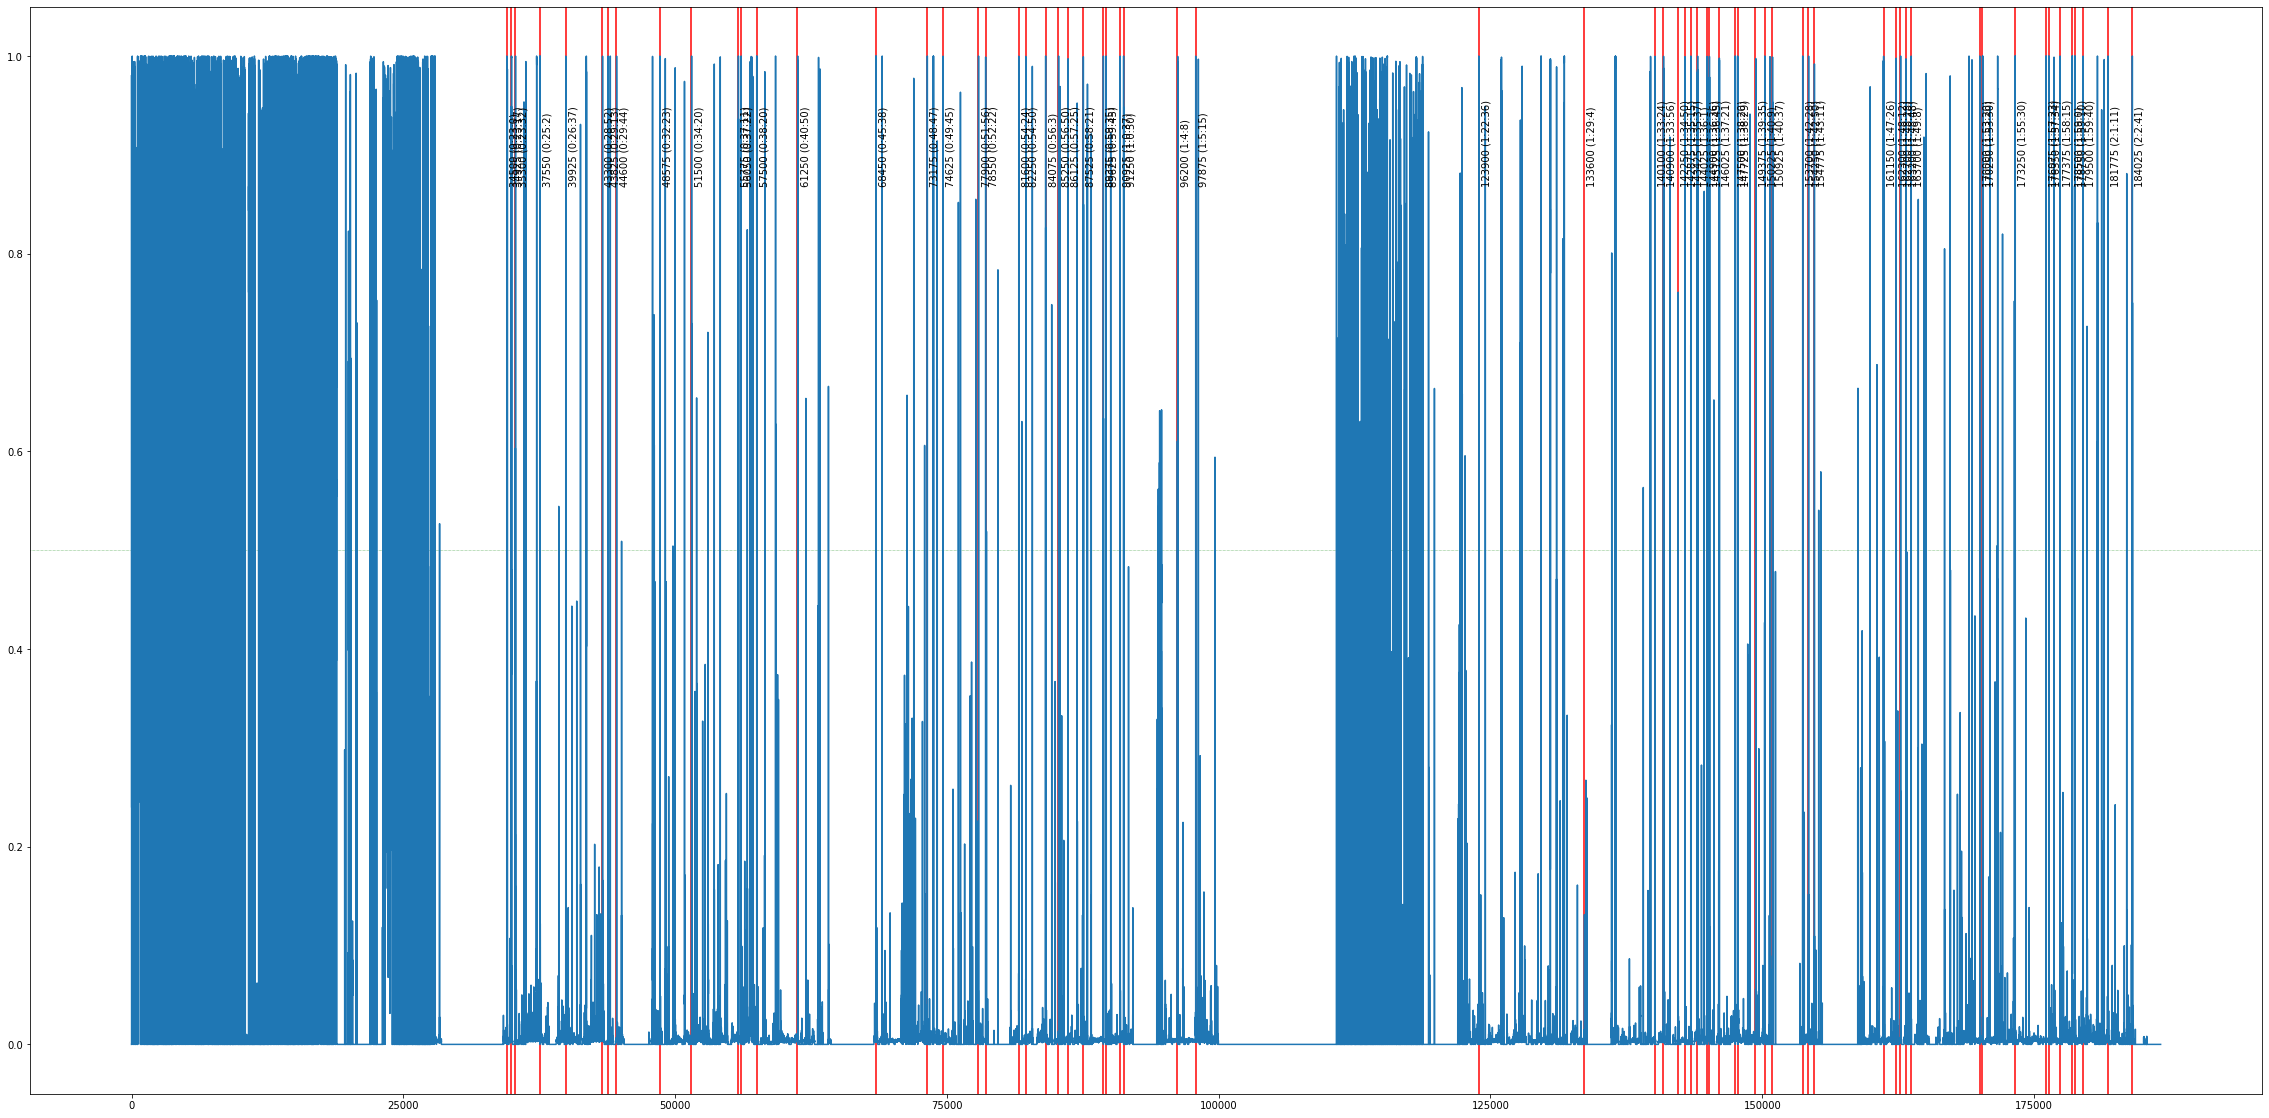

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (40, 20)

plot_frames_points(frame_confidence, true_frame, frame_per_second)

In [ ]:
#Find peaks

frame_tollerance = frame_per_second*3
peak_indices = signal.find_peaks(frame_confidence, height=.5, distance = frame_tollerance)
peaks_list = peak_indices[0]

print(f"Total Peaks Found: {len(peaks_list)}")

Total Peaks Found: 451


In [ ]:
#Remove pauses

game_start = "22:41"
game_pause_start = "1:06:36"
game_pause_end = "1:31:30"
game_end = "2:03:21"

f_game_start = hms_to_s(game_start) * frame_per_second
f_game_pause_start = hms_to_s(game_pause_start) * frame_per_second
f_game_pause_end = hms_to_s(game_pause_end) * frame_per_second
f_game_end = hms_to_s(game_end) * frame_per_second

prediction_without_pauses = [x for x in peaks_list if x > f_game_start and x < f_game_end]
final_predictions = [x for x in prediction_without_pauses if not (x > f_game_pause_start and x < f_game_pause_end)]

print(f"Total Peaks found without pauses: {len(final_predictions)}")

Total Peaks found without pauses: 146


In [ ]:
found_points = 0

for t in true_frame:
  for p in final_predictions:
    if t > p - frame_tollerance and t < p + frame_tollerance:
      found_points += 1
      break

notfound_points = len(true_frame) - found_points
wrong_points = len(final_predictions) - found_points

In [ ]:
print(f"True Positive: {found_points}")
print(f"False Negative: {notfound_points}")
print(f"False Positive: {wrong_points}")

True Positive: 64
False Negative: 2
False Positive: 82


In [ ]:
precision = found_points/len(final_predictions)
recall = found_points/len(true_frame)
f1_score = 2 * (precision*recall)/(precision+recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.4383561643835616
Recall: 0.9696969696969697
F1 Score: 0.6037735849056604


## Highlights

Final Result: [Youtube Video](https://youtu.be/WfsedD_gxaE)

The video is 17:04 long (7 second for predicted point) and contain some interesting choices

More info on the Python Script created for create Highlights given a video, minutes and ads here: [Highlights-Automation GitHub](https://github.com/isBre/Highlights-Automation)

In [ ]:
get_minutes = [frame_to_hms(x, frame_per_second) for x in final_predictions]

In [ ]:
#To execute the script code that performs the highlights for me 
#I need to have a txt file that collects all the minutes of the points 
#predicted by the machine

file = open('minutes.txt','w')
file.write(" ".join(get_minutes))
file.close()

## Final Consideration and Future Implementations
To conclude the project, I would like to report on the pros and cons of the following project:

**PROS**:
* **Excellent recall**; in fact, it could be useful as a tool to support the creation of highlights. I will then have to choose, from the baskets proposed by the model (about half of which are incorrect), which ones to include in the highlights.
* **Small Datasets but good performances**; although I did not initially have the dataset with the images to give to the model it was necessary to invest little time in creating a small dataset to get good results. In the future, using a larger and more diverse dataset could greatly increase the results obtained.

**CONS**:
* **Very poor computation performance**; the model takes more than an hour to make inference on a match of about two hours 1280x720. I tried using some tricks such as switching a model half the size to yolo, but that still did not do the trick. In the future it will be critical to focus on this part (perhaps optimizing the way frames are handled and parallelize as much as possible between GPUs)
* **Very bad points filtering**; another point to invest time in is to perform a filter on the baskets obtained from the model. As can also be seen from the highlights produced by the model many of the misclassified baskets are given by the fact that in perspective the ball is close to the basket (for example on throw-ins from the back when the ball is stationary for a long time). The model seems very confident in this area getting a suspiciously long sequence of spikes on the graph.